In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from dataset import TranslationDataset, tokenize_data, prepare_datasets

In [9]:
print(f"Number of CPU cores: {os.cpu_count()}")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Number of CPU cores: 11


In [10]:
batch_size = 16
max_seq_length = 300
epochs = 3

In [11]:
with open('/Users/venu/Documents/Productivity/Pytorch Tutorials/en-te/English_Text.txt',"r") as f:
    english_text = f.readlines()

with open('/Users/venu/Documents/Productivity/Pytorch Tutorials/en-te/Telugu_Text.txt',"r") as f:
    telugu_text = f.readlines()

In [12]:
english_text[-4:],telugu_text[-4:]

(['Heres a look at some of them. \n',
  'For this Rs. \n',
  'Everyone lives happily ever after. \n',
  '\n'],
 ['వాటిలో కొన్నిటిని మీకు అందిస్తున్నాము పరిశీలించండి. \n',
  'ఇందులో ఆహారం వండేందు కు రూ. \n',
  'అన్ని ప్రజలు తర్వాత ఎప్పుడైనా సంతోషంగా నివసిస్తున్నట్లు. \n',
  '\n'])

In [13]:
# Limiting number of sentences for training
len(english_text), len(telugu_text)

(4946036, 4946036)

In [14]:
# Limiting number of sentences for training
len(english_text), len(telugu_text)

(4946036, 4946036)

In [15]:
TOTAL_SENTENCES = 20000

In [16]:
english_sentences = english_text[:TOTAL_SENTENCES]
telugu_sentences = telugu_text[:TOTAL_SENTENCES]
len(english_sentences), len(telugu_sentences)

(20000, 20000)

In [17]:
# stripping new line
english_sentences = [sentence.rstrip('\n') for sentence in english_sentences]
telugu_sentences = [sentence.rstrip('\n') for sentence in telugu_sentences]

In [18]:
# checking max lenght of english and telugu sentences
max_english_sentence_lenght = max(len(sentence) for sentence in english_sentences)
max_telugu_sentence_length = max(len(sentence) for sentence in telugu_sentences)
max_english_sentence_lenght, max_telugu_sentence_length

(778, 1218)

/var/folders/yb/r3k6h0y11431_5th45hwjmjr0000gn/T/ipykernel_42455/2461350469.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([english_lengths, telugu_lengths], labels=['English', 'Telugu'])


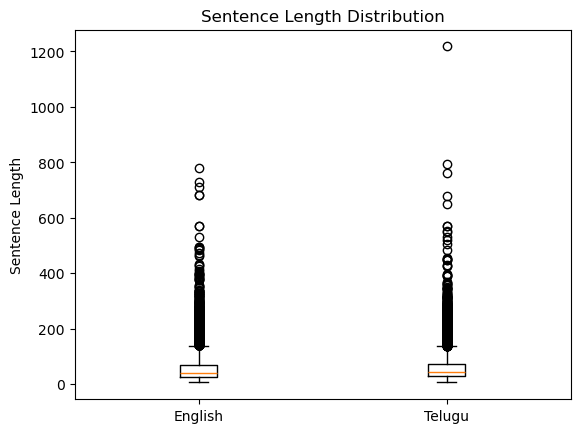

In [19]:
import matplotlib.pyplot as plt

# Calculate sentence lengths
english_lengths = [len(sentence) for sentence in english_sentences]
telugu_lengths = [len(sentence) for sentence in telugu_sentences]

# Plot boxplots
plt.boxplot([english_lengths, telugu_lengths], labels=['English', 'Telugu'])
plt.ylabel('Sentence Length')
plt.title('Sentence Length Distribution')
plt.show()

In [20]:
# restricting the max length sentences to be allowed to 97 percentile
# Calculate sentence lengths
en_sentence_lengths = [len(sentence) for sentence in english_sentences]
te_sentence_lengths = [len(sentence) for sentence in telugu_sentences]

# Calculate desired percentile
percentile = 97
en_value = np.percentile(en_sentence_lengths, percentile)
te_value = np.percentile(te_sentence_lengths, percentile)

print(f"English sentences under {percentile}th percentile: {en_value}")
print(f"Telugu sentences under {percentile}th percentile: {te_value}")

English sentences under 97th percentile: 176.0
Telugu sentences under 97th percentile: 168.0


In [21]:
# passing sentences only if they have length less then the max sequence length
def is_valid_length(sentence, max_seq_length):
    return len(list(sentence)) < (max_seq_length - 1)

In [22]:
valid_sentence_indices = []

for index in range(len(telugu_sentences)):
    telugu_sentence, english_sentence = telugu_sentences[index], english_sentences[index]
    if is_valid_length(telugu_sentence, max_seq_length)\
    and is_valid_length(telugu_sentence, max_seq_length):
        valid_sentence_indices.append(index)

In [23]:
print(f"Number of sentences taken: {len(english_sentences)}")
print(f"Number of Valid Sentences - {len(valid_sentence_indices)}")

Number of sentences taken: 20000
Number of Valid Sentences - 19938


In [24]:
valid_telugu_sentences = [telugu_sentences[i] for i in valid_sentence_indices]
valid_english_sentences = [english_sentences[i] for i in valid_sentence_indices]

len(valid_english_sentences), len(valid_telugu_sentences)

(19938, 19938)

In [25]:
valid_english_sentences[-3:], valid_telugu_sentences[-3:]

(['At the Canada Open Super 100 tournament, Parupalli Kashyap and Sourabh Verma progressed to the pre-quarterfinals. ',
  'Soon after ... ',
  '"""We don\'t believe this government." '],
 ['కెనడాలోని క్లాగరీ వేదికగా జరుగుతున్న కెనడా ఓపెన్\u200c సూపర్ 100 బ్యాడ్మింటన్\u200c టోర్నీలో కామన్వెల్త్ గేమ్ ఛాంపియన్ పారుపల్లి కశ్యప్\u200c, సౌరభ్\u200c వర్మలు ప్రీక్వార్టర్\u200c ఫైనల్లోకి ప్రవేశించారు. ',
  'మరికొద్ది సేపట్లో . ',
  '‘‘ మనం ఇటువంటి పాలనను మనం నమ్మలేము. '])

In [26]:
# lets format the data in mBart accepted format
ENGLISH_LANG_CODE = "[en_XX]"
TELUGU_LANG_CODE = "[te_IN]"
HINDI_LANG_CODE = "[hi_IN]"
EOS_CODE = "[eos]"

In [27]:
source_eng_tel_trans = [f"{ENGLISH_LANG_CODE}{sentence}{EOS_CODE}" for sentence in valid_english_sentences]
target_telugu_trans = [f"{TELUGU_LANG_CODE}{sentence}{EOS_CODE}" for sentence in valid_telugu_sentences]

In [28]:
source_eng_tel_trans[100], target_telugu_trans[100]

('[en_XX]She has two daughters. [eos]',
 '[te_IN]జీత్\u200cరాంకు ఇద్దరు కూతుళ్లు. [eos]')

In [29]:
from sklearn.model_selection import train_test_split

# Split the data into train and validation
train_src, test_val_src, train_tgt, test_val_tgt = train_test_split(
    source_eng_tel_trans, target_telugu_trans, test_size = 0.2, random_state = 99
)

In [30]:
len(train_src), len(test_val_src), len(train_tgt), len(test_val_tgt)

(15950, 3988, 15950, 3988)

In [31]:
# split the validation data into test and validation data
val_src, test_src, val_tgt, test_tgt = train_test_split(
    test_val_src, test_val_tgt, test_size = 0.5, random_state=99
)

In [32]:
len(val_src), len(val_tgt), len(test_src), len(test_tgt)

(1994, 1994, 1994, 1994)

In [26]:
!pip install transformers sentencepiece torch

In [35]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

In [36]:
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [29]:
# Set the tokenizer's source and target language
tokenizer.src_lang = "en_XX"
tokenizer.tgt_lang = "te_IN"

train_dataset, val_dataset, test_dataset = prepare_datasets(train_src, 
                                                                     train_tgt, 
                                                                     val_src, 
                                                                     val_tgt, 
                                                                     test_src, 
                                                                     test_tgt, 
                                                                     tokenizer,
                                                                     device,
                                                                     batch_size= batch_size)

/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/dataset.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_encodings = {key: torch.tensor(val).to(device) for key, val in train_encodings.items()}
/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/dataset.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_encodings = {key: torch.tensor(val).to(device) for key, val in val_encodings.items()}
/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/dataset.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

In [30]:
# Move model to CPU
model.to(device)

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    

In [31]:

for batch in train_dataloader:
    print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["labels"].shape)
    break

NameError: name 'train_dataloader' is not defined

In [32]:
model.to(device)
print(model.config)

MBartConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "facebook/mbart-large-50-many-to-many-mmt",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "MBartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABE

In [33]:
!pip install tf-keras

In [34]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir='/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/mbart50_translation_results',  # Output directory
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    learning_rate=5e-5,  # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,  # Batch size for evaluation
    weight_decay=0.01,  # Weight decay
    save_total_limit=3,  # Limit the number of saved models
    num_train_epochs=epochs,  # Number of training epochs
    predict_with_generate=True,  # Enable text generation during evaluation
    logging_dir="/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/logs",  # Log directory
    logging_steps=200,  # Log every 200 steps
    save_strategy="epoch",  # Save the model every epoch
    gradient_accumulation_steps=2,  # For effective batch size
    report_to="none",  # No logging to WandB or MLflow
    fp16=torch.cuda.is_available() if torch.cuda.is_available else False,  # Enable mixed precision if using GPU
    no_cuda= True,
    dataloader_num_workers=11,
    dataloader_pin_memory= False
)

print(training_args)

Seq2SeqTrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=11,
dataloader_persistent_workers=False,
dataloader_pin_memory=False,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPO

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1583: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [35]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,   # Training dataset
    eval_dataset=val_dataset,      # Validation dataset
    tokenizer=tokenizer
)

print("Trainer Loaded successfully!")

Trainer Loaded successfully!


/var/folders/yb/r3k6h0y11431_5th45hwjmjr0000gn/T/ipykernel_26740/4266720679.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [36]:
trainer.train()

  0%|          | 0/492 [00:00<?, ?it/s]

{'loss': 1.3437, 'grad_norm': 1.058494210243225, 'learning_rate': 2.9674796747967482e-05, 'epoch': 0.41}
{'loss': 0.3278, 'grad_norm': 0.9934787750244141, 'learning_rate': 9.34959349593496e-06, 'epoch': 0.81}


/opt/anaconda3/lib/python3.12/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


  0%|          | 0/123 [00:00<?, ?it/s]

{'eval_loss': 0.31246742606163025, 'eval_runtime': 3670.6925, 'eval_samples_per_second': 0.536, 'eval_steps_per_second': 0.034, 'epoch': 1.0}
{'train_runtime': 43092.6818, 'train_samples_per_second': 0.365, 'train_steps_per_second': 0.011, 'train_loss': 0.737734941932244, 'epoch': 1.0}


TrainOutput(global_step=492, training_loss=0.737734941932244, metrics={'train_runtime': 43092.6818, 'train_samples_per_second': 0.365, 'train_steps_per_second': 0.011, 'total_flos': 6663077501337600.0, 'train_loss': 0.737734941932244, 'epoch': 1.0})

In [38]:
from sacrebleu import corpus_bleu

def calculate_bleu_score(predictions, references):
    # Ensure references are in the expected format [[ref1, ref2, ...], [ref1, ref2, ...]]
    references = [[ref] for ref in references]  # SacreBLEU expects nested list
    bleu = corpus_bleu(predictions, references)
    return bleu.score

# Evaluate the BLEU score for test set
test_tgt_texts = test_tgt[:10]  # Taking the corresponding ground truth
bleu_score = calculate_bleu_score(translated_texts, test_tgt_texts)

print(f"BLEU Score: {bleu_score:.2f}")

BLEU Score: 4.46


In [4]:
# Define the save path
save_directory = '/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/mbart50_translation_model_lit'

# Save the fine-tuned model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print("Model and tokenizer saved successfully!")

NameError: name 'model' is not defined

In [37]:
# Load the model and tokenizer
model = MBartForConditionalGeneration.from_pretrained(save_directory)
tokenizer = MBart50TokenizerFast.from_pretrained(save_directory)

# Move to device (use CPU if no GPU is available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded successfully for inference!")

Model loaded successfully for inference!


In [38]:
def translate_text(input_text, src_lang="en_XX", tgt_lang="te_IN", max_length=200):
    tokenizer.src_lang = src_lang
    model.eval()  # Set model to evaluation mode

    # Prepare input text with language tokens
    formatted_input = f"{src_lang} {input_text} [eos]"

    # Tokenize and move input to the correct device
    inputs = tokenizer(formatted_input, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Generate translation
    with torch.no_grad():
        generated_ids = model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang])

    translated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return translated_text

In [42]:
user_input = """Hello World. I am a language Translator and my job is to translate given english sentence into Telugu language. 
I hope I perform well in my job. Wish me all the luck."""
translation = translate_text(user_input)
print(f"Telugu Translation: {translation}")

Telugu Translation: హలో ప్రపంచ. నేను ఒక భాష ట్రిస్టవర్ మరియు నా ఉద్యోగం ఇవ్వబడింది ఇంగ్లీష్ క్రమాన్ని ట్రిగో భాషలో ట్రిస్టట్ చేయడానికి ఉంది. నా ఉద్యోగంలో మంచి పని చేస్తున్నాను ఆశిస్తున్నాము. నాకు అన్ని అదృష్టం అనుకరించి. [eos]


In [40]:
# Run inference

sentences = [
    "I love machine learning.",
    "What is your favorite book?",
    "Let's meet at the coffee shop.",
    "The weather is very nice today."
]

for sentence in sentences:
    print(f"EN: {sentence}")
    print(f"TE: {translate_text(sentence)}\n")

EN: I love machine learning.
TE: నేను మెషిన్ లెర్నింగ్ ప్రేమ. [eos]

EN: What is your favorite book?
TE: మీ ఇష్టమైన పుస్తకం ఏమిటి? [eos]

EN: Let's meet at the coffee shop.
TE: కాఫీ షాప్ లో కలిసేలా. [eos]

EN: The weather is very nice today.
TE: ఈరోజు వాతావరణం బాగా ఉంది. [eos]

